In [30]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [31]:
# import all pyphysio classes and methods
import pyphysio as ph

In [32]:
# import data and creating a signal
# note: RAW-data file used pp7_744346
df_BVP = pd.read_csv('BVP_pp7_true.csv', header=None)


In [33]:
#count rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    270479
dtype: int64


In [34]:
#actual recording time 61 mins = 3660s 
#3660*4=n_rows
n_of_rows_keep = 3660*64
print(n_of_rows_keep)

234240


In [35]:
#using pandas to drop all the rows / seconds after 3720s 
df_BVP = df_BVP.drop(df_BVP.index[234240:270479])
print(df_BVP)

           0
0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
...      ...
234235 -3.53
234236 -4.02
234237 -3.99
234238 -3.48
234239 -2.76

[234240 rows x 1 columns]


In [36]:
#create BVP signal 
fsamp = 64  #64 Hz 
t_start = 0

ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')

In [37]:
print(ecg.get_start_time())

0


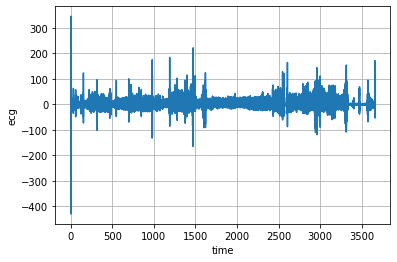

In [38]:
ecg.plot()

In [39]:
ibi = ph.BeatFromECG()(ecg)

In [40]:
ibi.get_duration() #seconds 

3660.0

In [41]:
# create label
label = np.zeros(3660)
label[0:600] = 1
label[600:3660] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [42]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [43]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [44]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

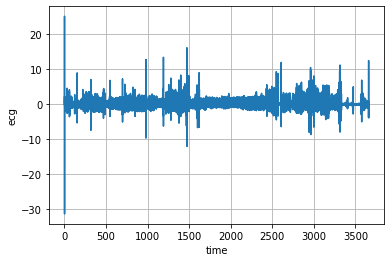

In [45]:
ecg.plot()

In [46]:
ibi = ph.BeatFromECG()(ecg)

In [48]:
ibi.get_duration()

3660.0

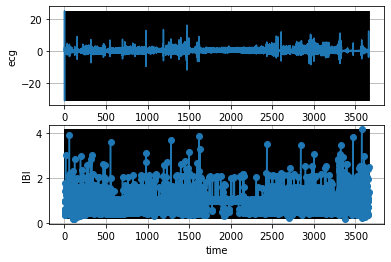

In [49]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [50]:
### physiological indicators 

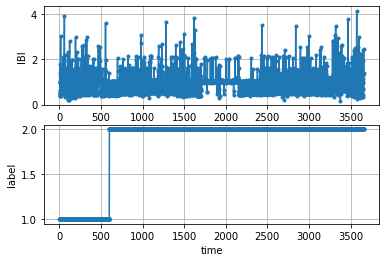

In [51]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [52]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [53]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [54]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1d865e90>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1d86b950>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1d865250>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1d8733d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1d8738d0>,
 'means': []}

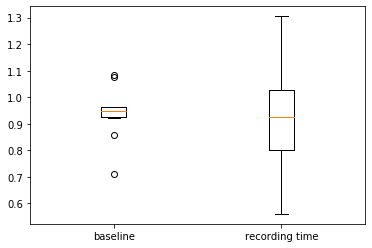

In [55]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['baseline', 'recording time'])

In [56]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [57]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [58]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp7_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp7_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.233887,61.233887,1.0,370.040087,1006.653809,957.451322,2995.710409
1,61.233887,121.233887,1.0,127.028022,513.992702,586.369705,1914.680362
2,121.233887,181.233887,1.0,225.128172,484.878819,682.629005,2101.278780
3,181.233887,241.233887,1.0,148.525310,458.250297,650.502507,2055.366721
4,241.233887,301.233887,1.0,142.165441,412.902781,718.793925,2034.486523
5,301.233887,361.233887,1.0,175.855482,602.765191,757.734346,2261.962044
6,361.233887,421.233887,1.0,135.327995,358.485038,837.116263,2078.818484
7,421.233887,481.233887,1.0,324.440659,607.638177,687.788789,2337.188415
8,481.233887,541.233887,1.0,416.449847,442.829935,573.395752,2159.061401
9,601.233887,661.233887,2.0,109.473968,384.599029,688.190941,1972.941137


In [60]:
#save data 
FD_HRV_pp7_df.to_csv('FD_HRV_pp7.csv')